# Milestone 3: Genre Prediction Using Standard ML Classifiers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn import preprocessing

from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora, models
import gensim

import string
import time
from datetime import datetime
from __future__ import division

Let's begin by loading and examining our raw dataset, containing data obtained through the TMDB API and saved previously as a CSV file.

In [5]:
%cd ./Train_Data_Version_1/
features = pd.read_csv('features_V1.csv')

IOError: File features_V1.csv does not exist

In [3]:
features.head(5)

,id,imdb_id,title,original_title,release_date,overview,tagline,budget,revenue,popularity,...,spoken_languages_ur,spoken_languages_uz,spoken_languages_vi,spoken_languages_wo,spoken_languages_xh,spoken_languages_xx,spoken_languages_yi,spoken_languages_za,spoken_languages_zh,spoken_languages_zu
0,10895,tt0032910,Pinocchio,Pinocchio,1940-02-23,Lonely toymaker Geppetto has his wishes answer...,For anyone who has ever wished upon a star.,2600000,84300000,2.418732,...,0,0,0,0,0,0,0,0,0,0
1,223,tt0032976,Rebecca,Rebecca,1940-04-12,A self-conscious bride is tormented by the mem...,The shadow of this woman darkened their love.,1288000,6000000,1.583448,...,0,0,0,0,0,0,0,0,0,0
2,756,tt0032455,Fantasia,Fantasia,1940-11-13,Fantasia is the adventurous 1940 experiment fr...,Hear the pictures! See the music!,2280000,83320000,1.498824,...,0,0,0,0,0,0,0,0,0,0
3,981,tt0032904,The Philadelphia Story,The Philadelphia Story,1940-12-01,Philadelphia heiress Tracy Lord throws out her...,Broadway's howling year-run comedy hit of the ...,0,0,1.113673,...,0,0,0,0,0,0,0,0,0,0
4,914,tt0032553,The Great Dictator,The Great Dictator,1940-10-15,Dictator Adenoid Hynkel tries to expand his em...,Once again - the whole world laughs!,2000000,11000000,1.005436,...,0,0,0,0,0,0,0,0,0,0


Next we'll load our previously dummy-coded genre labels and verify they look as expected.

In [4]:
labels = pd.read_csv('multilabels.csv')

In [5]:
labels.head(5)

,Action,Drama,Comedy,Family,Romance,Documentary,Horror
0,0,0,0,1,0,0,0
1,1,1,0,0,1,0,0
2,1,1,0,1,0,0,0
3,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0


Now, we begin preparing the data for model fitting.  The first step in this process is to remove or reformat features that are not suitable, i.e. numeric.

In [6]:
#delete text only data
features = features.drop(features.columns[[0, 1, 2, 3, 5, 6, 12]], axis=1)
features.head(5)

,release_date,budget,revenue,popularity,vote_count,vote_average,runtime,adult,n_actors,n_crew,...,spoken_languages_ur,spoken_languages_uz,spoken_languages_vi,spoken_languages_wo,spoken_languages_xh,spoken_languages_xx,spoken_languages_yi,spoken_languages_za,spoken_languages_zh,spoken_languages_zu
0,1940-02-23,2600000,84300000,2.418732,933,6.8,88.0,False,12.0,75.0,...,0,0,0,0,0,0,0,0,0,0
1,1940-04-12,1288000,6000000,1.583448,271,7.6,130.0,False,25.0,37.0,...,0,0,0,0,0,0,0,0,0,0
2,1940-11-13,2280000,83320000,1.498824,615,7.1,124.0,False,7.0,24.0,...,0,0,0,0,0,0,0,0,0,0
3,1940-12-01,0,0,1.113673,160,7.6,112.0,False,28.0,13.0,...,0,0,0,0,0,0,0,0,0,0
4,1940-10-15,2000000,11000000,1.005436,563,8.0,125.0,False,59.0,22.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#convert release date string to numeric year
rd = features['release_date'].str[:4]
rd = pd.to_numeric(rd)

features['release_date'] = rd
features.head()

,release_date,budget,revenue,popularity,vote_count,vote_average,runtime,adult,n_actors,n_crew,...,spoken_languages_ur,spoken_languages_uz,spoken_languages_vi,spoken_languages_wo,spoken_languages_xh,spoken_languages_xx,spoken_languages_yi,spoken_languages_za,spoken_languages_zh,spoken_languages_zu
0,1940.0,2600000,84300000,2.418732,933,6.8,88.0,False,12.0,75.0,...,0,0,0,0,0,0,0,0,0,0
1,1940.0,1288000,6000000,1.583448,271,7.6,130.0,False,25.0,37.0,...,0,0,0,0,0,0,0,0,0,0
2,1940.0,2280000,83320000,1.498824,615,7.1,124.0,False,7.0,24.0,...,0,0,0,0,0,0,0,0,0,0
3,1940.0,0,0,1.113673,160,7.6,112.0,False,28.0,13.0,...,0,0,0,0,0,0,0,0,0,0
4,1940.0,2000000,11000000,1.005436,563,8.0,125.0,False,59.0,22.0,...,0,0,0,0,0,0,0,0,0,0


There are a decent number of movies that are missing data for some of the features.  Since we can't fit our models with NaN values present, we can choose to either remove these movies, or impute values for the missing features.  Let's see how many movies we lose by dropping observations with any missing values.

In [8]:
# Count missing data to see how many movies we lose by dropping NAs:
features.shape[0] - features.dropna().shape[0]

11578

So we'll lose almost 12K movies by dropping those with any missing values.  Given the large size of our datset, this doesn't seem unmanageable.

In [39]:
#make a df with no important features missing
feat2 = pd.concat([features, labels], axis=1)
feat2 = feat2.dropna()
labels2 = feat2.ix[:,514:521]

#drop adult since it is always false
del feat2['adult']

We also need to worry about features that have erroneous or nonsensical values, e.g. a budget of $0.00.  These erroneous values could have a negative influence on the model, if they're not dealt with.  So we'll create a new dataset with erroneous values replaced by the mean, with which we'll compare the non-altered dataset later.

In [10]:
#make a second df with imputed mean values for nonsensical data in quantitative variables
feat3 = feat2.iloc[:,0:9].values
feat3 = feat3.astype('float')
feat3[feat3 == 0] = np.nan
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
feat3 = imp.fit_transform(feat3)

In [11]:
feat3 = pd.DataFrame(feat3, columns = list(feat2)[0:9])
feat3 = pd.concat([feat3, feat2.iloc[:,10:520]], axis=1).dropna()
feat3.head()

,release_date,budget,revenue,popularity,vote_count,vote_average,runtime,n_actors,n_crew,original_language_ab,...,spoken_languages_za,spoken_languages_zh,spoken_languages_zu,Action,Drama,Comedy,Family,Romance,Documentary,Horror
0,1940.0,2.600000e+06,8.430000e+07,2.418732,933.0,6.8,88.0,12.0,75.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1940.0,1.288000e+06,6.000000e+06,1.583448,271.0,7.6,130.0,25.0,37.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1940.0,2.280000e+06,8.332000e+07,1.498824,615.0,7.1,124.0,7.0,24.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1940.0,1.523739e+07,6.234904e+07,1.113673,160.0,7.6,112.0,28.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1940.0,2.000000e+06,1.100000e+07,1.005436,563.0,8.0,125.0,59.0,22.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
# Pop labels off of imputed dataset
labels3 = feat3.ix[:,512:519]
feat3 = feat3.drop(feat3.columns[[512, 513, 514, 515, 516, 517, 518]], axis=1)
feat2 = feat2.drop(feat2.columns[[513, 514, 515, 516, 517, 518, 519]], axis=1)

## Model fitting and comparison

Now that we've cleaned up our data sufficiently, it's finally time to begin model fitting and comparison.  The first step is to split the full dataset into training and testing sets.

In [13]:
#split our data into training and testing
X_train, X_test, y_train, y_test = train_test_split(feat2, labels2, test_size=0.33, random_state=42)

# ----------------------------
# Standardize features
scaler = preprocessing.StandardScaler().fit(X_train)
# Call: scaler.transform(X_train) to scale
# ----------------------------

### General strategy

We framed our genre prediction problem as a multi-label task, where a given movie may have >=1 genre labels.  Rather than throwing out movies with >1 genre, or arbitrarily choosing to keep a single genre for each movie, we chose this framework because we believe this approach retains an important aspect of movie genres - that boundaries are often not clear - at the cost of making the classification task more difficult.

**Classification scheme:**
We first chose to tackle the multi-label task by using a one-vs.-rest classification approach, essentially modeling each genre as the output of a single classifier, since it requires only fitting one classifier per genre.  It's not the most powerful approach, but it more efficient than other classification schemes and is expected to give decent first-pass results.

**Model selection:**
We wound up fitting three different models to the data - Naive Bayes (NB), Logistic regression (LR), and Random Forests Classifier (RFC) - fitting the LR and RFC with, and without, PCA.

**Class imbalance**
As we showed in previous milestones, the genres are not all equally common, therefore we have to contend with significant class imbalance.   This could be dealt with in a number of ways, but the way we chose to deal with it is to "balance" the groups by adjusting the weights to be inversely proportional to the class frequencies for the LR and and RFC, and setting the priors in NB to the observed frequencies.

**Performance Evaluation:**
To evaluate performance, we chose to Hamming loss.  We chose Hamming loss, as opposed to other measures, because it gives the label-by-label accuracy for our multi-label classification, and not an "all or nothing" accuracy indicating whether we got the exact combination of genres right for a particular movie. 

### Naive Bayes classifier

We decided to begin our modeling efforts with a simple Naive Bayes classifier.  The Naive Bayes classifier should be simple to implement and quick to fit this large dataset, so it's a good place to start.

In [14]:
from sklearn.naive_bayes import GaussianNB

# Do multi-label NB
nb_mdl = OneVsRestClassifier(GaussianNB(), n_jobs=-1)
nb_mdl.fit(X_train, y_train)

OneVsRestClassifier(estimator=GaussianNB(priors=None), n_jobs=-1)

In [15]:
# Test uncalibrated NB performance
nb_pred = nb_mdl.predict(X_test)
hamming_loss(y_test, nb_pred)

0.310183745244874

We can see that the NB model appears to do a decent job right out of the box, with a Hamming loss of 0.31.  This means that roughly 69% of our genre labels are predicted correctly for the test set.  Since each genre assignment is a 50/50 choice, this would seem to be a large improvement over a random classifier.  

We thought perhaps performance could be improved by tuning the NB model.  There isn't really a good way to 'tune' an NB classifier, but we can calibrate the class probabilities and look at how varying the class threshold affects our loss on the test set.

Minumum Hamming loss: 0.212766466493
Loss when zero: 0.214970572051


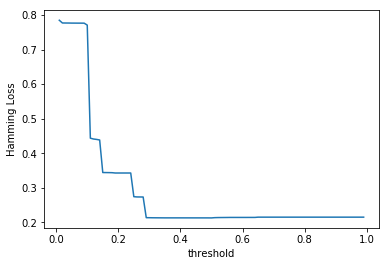

In [16]:
from sklearn.calibration import CalibratedClassifierCV

nb_sigmoid = CalibratedClassifierCV(GaussianNB(), method='sigmoid')
nb_mdl = OneVsRestClassifier(nb_sigmoid, n_jobs=-1)
nb_mdl.fit(X_train, y_train)

nb_cal_proba = nb_mdl.predict_proba(X_test)


loss = []
# Choose optimal threshold by manual ROC
for thresh in np.linspace(0.01, 0.99, 99):
    
    pred = np.array(nb_cal_proba > thresh).astype(int)
    loss.append(hamming_loss(y_test, pred))

    
plt.plot(np.linspace(0.01, 0.99, 99), loss)
plt.xlabel('threshold'); plt.ylabel('Hamming Loss')

print 'Minumum Hamming loss: {loss}'.format(loss=min(loss))
print 'Loss when zero: {loss}'.format(loss=hamming_loss(y_test, np.zeros(np.shape(y_test))))

Surprisingly, it seems like the NB classifier does best (Hamming loss = 0.213) at the higest thresholds - when it predicts everything as 0, i.e. no genre assigned.  In fact, it turns out that the best performance achievable here is what we would achieve by assigning no genre to any movie - the "all null" model (Hamming loss = 0.215).  This is clearly not the desired effect, since prediction of no genre is completely unhelpful.  We could try to impose a constraint on the model that at least one genre is always chosen, e.g. applying a softmax transformation, but this assumes labels are mutually exclusive, so it can't handle multi-label scenarios like this one.  To circumvent these issues, we decided to try something a bit different, and turned to logistic regression.

### Logistic regression

Now we implement a logistic regression model, using stochastic gradient descent to efficiently fit the large dataset.  As above, we fit our model on the full training dataset, using a one-vs.-rest scheme, and report the Hamming loss performance metric.  The model was previously tuned using the code in the Appendix, and C=100 was identified as the optimal regularization parameter value.  We use that value here.

In [17]:
from sklearn.linear_model import LogisticRegression

# Now do LR - we'll use the SGD solver since the dataset is so large
lr_mdl = OneVsRestClassifier(LogisticRegression(class_weight='balanced', C=100, solver='sag'), n_jobs=-1)
lr_mdl.fit(scaler.transform(X_train), y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)

In [18]:
# Test LR performance
lr_pred = lr_mdl.predict(scaler.transform(X_test))
hamming_loss(y_test, lr_pred)

0.35005203722755224

In [19]:
# Let's look at the first handful of genre predictions
lr_pred[:10]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 1],
       [1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 1, 0, 1]])

We can see that our untuned LR does worse than the NB model and how we would do by simply predicting all zeros for the genres (Hamming loss of 0.350 vs. 0.215), but at least it does assign movies at least one genre.  Presumably, performance would improve with some finer tuning of the regularization strength, but it seems doubtful that we will get too far with this model and this dataset.

### PCA

To see whether we can improve performance by reducing the dimensionality of the feature space we implemented PCA and kept the minimum number of PCs required to explain 90% of the total variance.  This will hopefully make the model fitting faster, and result in higher quality predictions. We will apply PCA to the logistic regression model above to see whether performance can be improved, and to the RFC below.

In [20]:
# implementation of LR using PCA to see if this results in better prediction
# start with 400 PCs, will only take the ones that explain ~90% of variance
pca = PCA(n_components=400)
pca.fit(scaler.transform(X_train))

PCA(copy=True, iterated_power='auto', n_components=400, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
# show the number of PCs that explain at least 90% of the variance
var90pcs = len(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_)<.9])
print var90pcs
print np.cumsum(pca.explained_variance_ratio_)[var90pcs]

327
0.900468664604


We can see that 90% of the variance is explained by the first 327 PCs, so we will fit our LR using the first 327 PCs and compare the results to the model using the entire dataset above.

In [22]:
# reduce data using PCA
X_train_reduced = pca.transform(scaler.transform(X_train))
print X_train_reduced.shape
X_test_reduced = pca.transform(scaler.transform(X_test))
print X_test_reduced.shape

(96981, 400)
(47768, 400)


In [23]:
# Now the same LR as above but with 327 principal components
lr_mdl_pca = OneVsRestClassifier(LogisticRegression(class_weight='balanced', C=100, solver='sag'), n_jobs=-1)
lr_mdl_pca.fit(X_train_reduced[:,0:var90pcs], y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)

In [24]:
# Test LR performance
lr_pred_pca = lr_mdl_pca.predict(X_test_reduced[:,0:var90pcs])
hamming_loss(y_test, lr_pred_pca)

0.35687070842404955

We can see that the Hamming loss is pretty similar to that achieved using the full data set, only slightly worse.  This indicates that the features aren't very compressible, i.e. information is distributed widely across features. It is possible that we will will see gains by implementing a more flexible classifier, so we decided to fit an RFC, and compare results with those above.

### Random Forest Classifier

As with the LR, we pre-tuned our RFC using the code in the Appendix and apply those values here.

In [25]:
#run a tuned RFC on full data set and calculate Hamming loss
# **tuning parameters chosen previously using code in the Appendix
rfc_mdl = RFC(n_estimators=120, max_depth=60, class_weight ='balanced', n_jobs=-1).fit(X_train,y_train)
rf_pred = rfc_mdl.predict(X_test)
hamming_loss(y_test, rf_pred)

0.16755688207287606

We can see that we achieve a significantly better Hamming score with RFC (0.17) than with NB or LR.  This means that roughly 83% of our genre labels are predicted correctly for the test set.

In [26]:
#calculate the overall accuracy of our predictions
rfc_mdl.score(X_test, y_test)

0.28720063640931165

We also compared the Hamming score metric with a more traditional overall accuracy metric.  From the sklearn documentation: "In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted." While interesting to compare to the Hamming loss, this gives us a much coarser picture of how our model is performing at assigning genres. 29% of our films' genres are predicted exactly as we assigned them, but 83% of our predicted genres are correct. Since a random classifier would need to assign seven binary genres correctly to get one movie correct on this harsh metric, each movie would have a (.5)^7 or roughly 0.8% chance of being assigned correctly. 

Next, we apply PCA and see whether dimensionality reduction improves RFC performance.

In [27]:
#run a tuned RFC on our data that has been reduced using PCA and calculate Hamming loss
rfc_mdl_pca = RFC(n_estimators=120, max_depth=60, class_weight = 'balanced').fit(X_train_reduced[:,0:var90pcs],y_train)
pred_pca = rfc_mdl_pca.predict(np.array(X_test_reduced[:,0:var90pcs]))
hamming_loss(y_test, pred_pca)

0.17694750819436803

About 82% of the genres are predicted correctly using PCA with 327 PCs. This is pretty comparable to the RFC above that uses the full dimension dataset. Perhaps the slight loss in accuracy is offset by the reduction in time it takes to fit the random forest, although this is a subjective judgment.

### Model Performance by genre

It's important to consider how the different models are making their mistakes, so we decided to break down the prediction accuracy by genre for the LR and RFC.

In [29]:
#visualize by-genre accuracy of predictions
def plot_acc_by_genre(pred, y_test, clf_str=''):
    
    preds = pd.DataFrame(pred)
    acc = []

    for i in range(7):
        a = np.array(y_test[[i]])
        b = np.array(preds[[i]])
        acc.append(np.count_nonzero(a==b) / preds.shape[0] * 100)

    plt.figure(figsize=(10,5))
    index = [0,1,2,3,4,5,6]
    plt.bar(index,acc,align="center")
    plt.xticks(index, ('Action', 'Drama', 'Comedy', 'Family', 'Romance', 'Documentary', 'Horror'))
    plt.ylim([0,100])
    plt.grid(axis='y')
    plt.title(clf_str + ' Accuracy by Genre')
    plt.ylabel('Accuracy')
    plt.show()

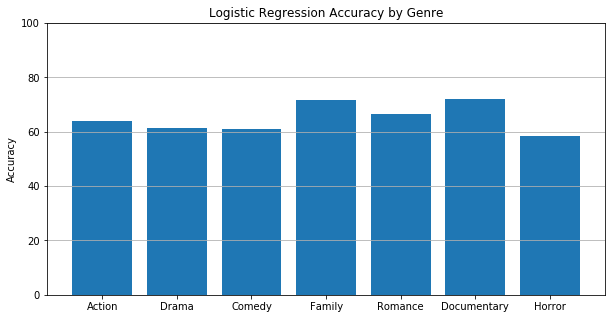

In [32]:
plot_acc_by_genre(lr_pred, y_test, 'Logistic Regression')

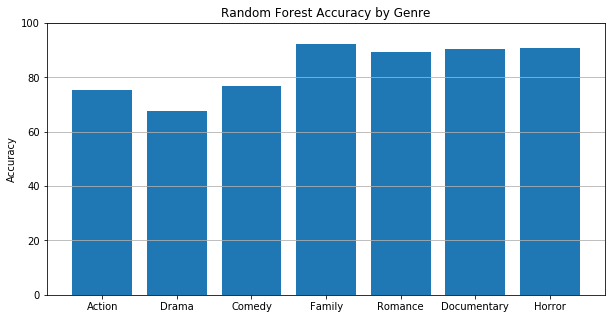

In [30]:
plot_acc_by_genre(rf_pred, y_test, 'Random Forest')

For the LR, accuracy is pretty similar across action, drama, comedy, and horror, while family and documentary genres are predicted with slightly higher fidelity.  

For RFC, we correctly identify 4 out of our 7 combined genres almost 90% of the time, while action and comedy are accurately labeled roughly 75% of the time. Drama is the only genre with a lower than 70% accuracy rating, indicating that we may need to rethink which of our original genres we are flagging for inclusion in this category. It is also a genre that appears with a wide variety of other film types, making its discrimination more difficult.

Overall, the LR and RFC don't look drastically different, beyond the overall higher performance of RFC.

## Exploring the importance of categorical features and effects of missing data in RF model

We next wanted to evaluate the contributions of different categorical variables we chose to include, as well as the effects of imputing data.  We first look at performance of our tuned RFC on the imputed dataset.

In [33]:
#split our imputed data df into training and testing
X_train3, X_test3, y_train3, y_test3 = train_test_split(feat3, labels3, test_size=0.33, random_state=42)

#run a RFC on our data with imputed data
imputedmdl = RFC(n_estimators=120, max_depth=60, class_weight = 'balanced', n_jobs=-1).fit(X_train3,y_train3)
pred3 = imputedmdl.predict(X_test3)
hamming_loss(y_test3, pred3)

0.20405906794877168

This means that roughly 80% of our genre labels are predicted correctly for the test set when using the dataset with imputed data. As this performance is worse than leaving erroneous value in place, we will continue to test other methods of handling missing / nonsensical data.

Next, we wondered whether including information about languages and production location significantly improved predictions.

In [34]:
#build several dfs with different predictors
a = X_train.ix[:,0:9] #just the basics
b = X_train.ix[:,0:132] #include original language
c = X_train.ix[:,0:365] #include production countries
d = X_train #include spoken language

e = X_test.ix[:,0:9] #just the basics
f = X_test.ix[:,0:132] #include original language
g = X_test.ix[:,0:365] #include production countries
h = X_test #include spoken language

In [35]:
#run models on each df
dfs_train = [a,b,c,d]
dfs_test = [e,f,g,h]
loss = []

for i in range(4):
    mdl = RFC(n_estimators=120, max_depth=60, class_weight = 'balanced', n_jobs=-1).fit(dfs_train[i],y_train)
    pred = mdl.predict(dfs_test[i])
    loss.append(hamming_loss(y_test, pred))
    
print loss

[0.17707311529535613, 0.1715434122066177, 0.16805931047682848, 0.16764959207598631]


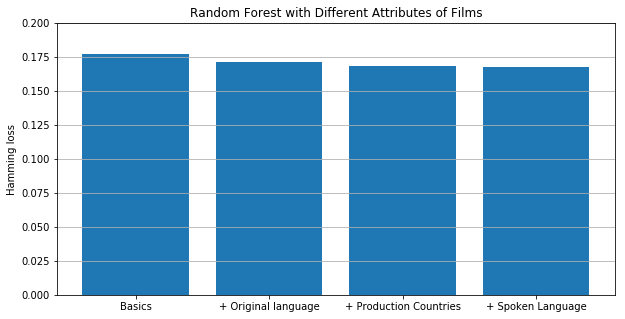

In [36]:
plt.figure(figsize=(10,5))
index = [0,1,2,3]
plt.bar(index,loss,align="center")
plt.xticks(index, ('Basics', '+ Original language', '+ Production Countries', '+ Spoken Language'))
plt.ylim([0,0.2])
plt.grid(axis='y')
plt.title('Random Forest with Different Attributes of Films')
plt.ylabel('Hamming loss')
plt.show()

As we can see, ading all our language and country predictors as indicator variables leads to a 1% improvement in classifier performance.  This is not a huge gain, but perhaps worth the added overhead.

Next, we wondered whether the different "basic" features had roughly similar importance for RFC predictions.  We evaluated this by looking at the RFC importance scores.

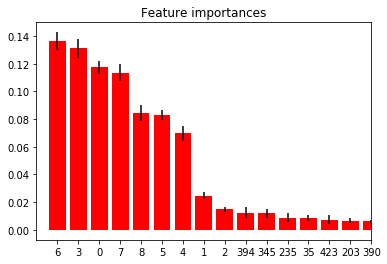

In [37]:
importances = rfc_mdl.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_mdl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, 15])
plt.show()

As we can see from the above visualization, seven features proved the most important in determining the movie genres for our Random Forest Classifier. The top nine contributors came from our "basic" core of quanitiative data scraped from TMDb and are, in order: running time, popularity, release year, # of actors, # of crew, vote average, and vote count. Budget and revenue come last among these variables and suffer from having a large amount of missing data compared to our other features.

In [38]:
# Print the full feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 6 (0.136471)
2. feature 3 (0.131113)
3. feature 0 (0.117326)
4. feature 7 (0.113605)
5. feature 8 (0.084507)
6. feature 5 (0.082935)
7. feature 4 (0.069611)
8. feature 1 (0.024706)
9. feature 2 (0.014729)
10. feature 394 (0.012339)
11. feature 345 (0.011786)
12. feature 235 (0.008720)
13. feature 35 (0.008469)
14. feature 423 (0.007209)
15. feature 203 (0.006606)
16. feature 390 (0.006119)
17. feature 166 (0.006049)
18. feature 403 (0.005994)
19. feature 396 (0.005037)
20. feature 201 (0.004618)
21. feature 62 (0.004548)
22. feature 227 (0.004233)
23. feature 183 (0.004148)
24. feature 421 (0.003273)
25. feature 470 (0.003135)
26. feature 232 (0.002911)
27. feature 145 (0.002812)
28. feature 194 (0.002714)
29. feature 508 (0.002537)
30. feature 43 (0.002503)
31. feature 31 (0.002501)
32. feature 489 (0.002429)
33. feature 219 (0.002287)
34. feature 383 (0.002267)
35. feature 511 (0.002264)
36. feature 307 (0.002250)
37. feature 413 (0.002086)
38. feature 243

### Appendix:  model tuning code

In [ ]:
# Tuning for LR model
loss = []

for tuning_param in np.array([0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0 100]):
    
    lr_mdl = OneVsRestClassifier(LogisticRegression(class_weight ='balanced', C=tuning_param, solver='sag'), n_jobs=-1)
    lr_mdl.fit(scaler.transform(X_train), y_train)

    # Test LR performance
    lr_pred = lr_mdl.predict(scaler.transform(X_test))
    loss.append(hamming_loss(y_test, lr_pred))
    
plt.plot([0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 100], loss)
plt.xlabel('regularization tuning parameter'); plt.ylabel('Hamming loss')

In [ ]:
# Tuning for random forest model

n_folds = 5
kf = KFold(n_splits=n_folds)

# Parameters for tuning a random forest model
n_trees = np.arange(10, 100, 20)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(2, 10)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# To keep track of the best model
best_score = 1

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'
    
for trees in n_trees:
    for depth in depths:
        loss = []
        for ktrain, ktest in kf.split(feat2):
            mdl = RFC(n_estimators=trees, max_depth=depth).fit(feat2.iloc[ktrain,:],labels2.iloc[ktrain,:])
            pred = mdl.predict(feat2.iloc[ktest,:])
            loss.append(hamming_loss(labels2.iloc[ktest,:], pred))
        # Record and report probability
        average_loss = np.mean(loss)
                   
        # Record and report accuracy
        print "Trees:", trees, "Depth:", depth, "Loss:", average_loss
        
        # Update our record of the best parameters seen so far
        if average_loss < best_score:
            best_score = average_loss
            best_trees = trees
            best_depth = depth

print 'Best number of trees, depth:', best_trees, ',', best_depth

In [ ]:
# Go higher in trees and depth

# Parameters for tuning a random forest model
depths = np.arange(50, 80, 10)

# To keep track of the best model
best_score = 1

kf = KFold(n_splits=3)

# Run grid search for model with 5-fold cross validation
print '3-fold cross validation:'
    
for trees in n_trees:
    for depth in depths:
        loss = []
        for ktrain, ktest in kf.split(feat2):
            mdl = RFC(n_estimators=160, max_depth=depth, class_weight = 'balanced').fit(feat2.iloc[ktrain,:],labels2.iloc[ktrain,:])
            pred = mdl.predict(feat2.iloc[ktest,:])
            loss.append(hamming_loss(labels2.iloc[ktest,:], pred))
        # Record and report probability
        average_loss = np.mean(loss)
                   
        # Record and report accuracy
        print "Trees:", trees, "Depth:", depth, "Loss:", average_loss
        
        # Update our record of the best parameters seen so far
        if average_loss < best_score:
            best_score = average_loss
            best_trees = trees
            best_depth = depth

print 'Best number of trees, depth:', best_trees, ',', best_depth